# WATER BAG PREDICTION PER CRITICAL REGION

### BASED ON INMET METHEOROLOGICAL STATIONS DATA

---
#### Change project root directory

In [1]:
cd ../

C:\Users\luisr\Desktop\Repositories\Data Science Projects\Hackaton COR IV - Centro de Operações do RJ\ACELERAÇÃO


#### Import modules and libraries

In [2]:
import os, json, pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns; sns.set()
from IPython.display import clear_output as co

#### Time series transformation & binary classification pipeline

from Modulos.timeserie_transform import TimeseriesTransformPipeline
from Modulos.imbalanced_selection import groupConsecutiveFlags, MinorityGroupSplitUndersample
from Modulos.imbalanced_classification import ClassificationPipeline, classesGroupRecall

#### Preprocessing and machine learning modules

from sklearn.preprocessing import MinMaxScaler as mms
from Modulos.cv_samplers import GroupUnderSampleSplit, print_cls_cnt

from sklearn.utils import all_estimators
from sklearn.metrics import classification_report as cr

from imblearn import ensemble
from imblearn.metrics import classification_report_imbalanced as cri

#  Classifier colleciton
classifiers = dict(all_estimators('classifier'))

# Specific classification models

gbc = classifiers['GradientBoostingClassifier']
brfc = ensemble.BalancedRandomForestClassifier

#### Metrics and scoring functions

from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, recall_score, precision_score

recall_0 = make_scorer(recall_score, pos_label=0)
recall_1 = make_scorer(recall_score, pos_label=1)
precision_0 = make_scorer(precision_score, pos_label=0)
precision_1 = make_scorer(precision_score, pos_label=1)

scoring = {
    'accuracy': 'accuracy',
    'recall': 'recall', 'precision': 'precision',
    'recall-0': recall_0, 'recall-1': recall_1,
    'precision-0': precision_0, 'precision-1': precision_1
}

c:\Users\luisr\anaconda3\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


---
## Load & Preprocess Data

In [3]:
from Modulos.waterbags import waterbag_project

project = waterbag_project(
    time_serie='clusters', freq='upsample', load_waterbags=True, 
    time_features=False, inmet_features=False, alerta_features=False,
)

data = project.data
group_ts = project.time_serie
waterbags = project.waterbags

# Drop records before july, 2018
data = data['2018-06':]
group_ts = group_ts['2018-06':]

---

# Data Transformation

In [4]:
time_features = [
    'year', 'month', 'day', 'hour', 'minute', 'date', 'time',
    'index', 'dayofyear', 'weekofyear', 'weekday', 'quarter'
]

### Select example water bag group

In [5]:
routes = waterbags.groupby(['sublabel', 'main_route']).first().index.to_frame().set_index('sublabel').to_dict()['main_route']
top_grps_cnt = waterbags['sublabel'].value_counts()
top_grps_hour = group_ts.sum().sort_values(ascending=False)

# top_grp = top_grps_cnt.index[2]
# top_grp = top_grps_hour.index[1]

top_grp = '1'

### Define feature dataset and target variables

#### Metheorological data after first registered waterbag event

In [6]:
print(f'Train and test sets for water bag group: {routes[int(top_grp)]}. (id: {top_grp})')
Y = group_ts[str(top_grp)].copy()

# group_min_time = Y[Y==1].index.min() # Group specific minimum time value
group_min_time = '2018-06'

X = TimeseriesTransformPipeline(
    data, # group_min_time,
    cut=-1, drop_empty_cols=True,
#     label_encode=time_features,
    scale=True, interpolate=None, fillna=None
)

Xf = TimeseriesTransformPipeline(
    X, interpolate='nearest', fillna='min'
)

Y = Y.loc[X.index]

groups = groupConsecutiveFlags(ts=Y)

display(pd.concat([Y.value_counts().to_frame('Class Count'), Y.value_counts(normalize=True).to_frame('Class Count')], 1))

Train and test sets for water bag group: Rua do Catete. (id: 1)
Initial data: (142867, 230)
Drop empty columns:  (142866, 217)
Initial data: (142866, 217)


,Class Count,Class Count
0.0,142083,0.994519
1.0,783,0.005481


### Target groups analysis

#### Water bag hour groups per day from 2018-06

In [7]:
days = (groups.index.max() - groups.index.min()).days
n_groups = groups.value_counts().iloc[1:].shape[0]

print('Water bag records groups:', n_groups)
print('Years in time serie:', round(days / 365, 2))
print('Hour groups per month:', round(n_groups / days * 30, 2))
print('15 min records per month:', round(Y.resample('M').sum().mean(), 2))
print('Hours per month:', round(Y.resample('M').sum().mean() / 4, 2))
print('Water bag time percentage:', round((groups != -1).mean() * 100, 3), '%')

Water bag records groups: 72
Years in time serie: 4.08
Hour groups per month: 1.45
15 min records per month: 15.98
Hours per month: 3.99
Water bag time percentage: 0.548 %


#### Period groups count

In [8]:
print('Unique groups:', len(groups.unique()), '\n')
display(groups.value_counts().head() / 4)

Unique groups: 73 



-1     35520.75
 18       10.50
 12        7.75
 40        6.25
 7         5.75
Name: group, dtype: float64

---
# Base line classification model

In [9]:
# Main parameters definition
seed = 0

n_splits = 5
train_size = 0.66
test_size = 0.33
train_prct = None
test_prct = None

# Model definition
model = gbc(n_estimators=100, random_state=seed)

### Fit base line model

In [10]:
### Instantiate classification pipeline object
CP = ClassificationPipeline(
    n_splits=n_splits,
    train_size=train_size, test_size=test_size,
    train_prct=train_prct, test_prct=test_prct,
    shuffle=True, random_state=seed,
)

# Model & Evaluate
score, cls_cnt = CP.binary(
    Xf, Y, model, groups=groups,
    strategy='GroupShuffleSplit',
    return_cls_cnt=True, store=True
)

cls_cnt.index = cls_cnt.index.astype('str')
display(pd.concat([score, cls_cnt['Train set']], 1))

,precision,recall,f1-score,support,Train set
0.0,0.996649,0.999365,0.998005,48813.000000,93270.0
1.0,0.761538,0.376426,0.503817,263.000000,514.0
accuracy,0.996027,0.996027,0.996027,0.996027,NaN
macro avg,0.879094,0.687895,0.750911,49076.000000,NaN
weighted avg,0.995389,0.996027,0.995357,49076.000000,NaN


### Evaluate multiple event groups

10/10 models evaluated.


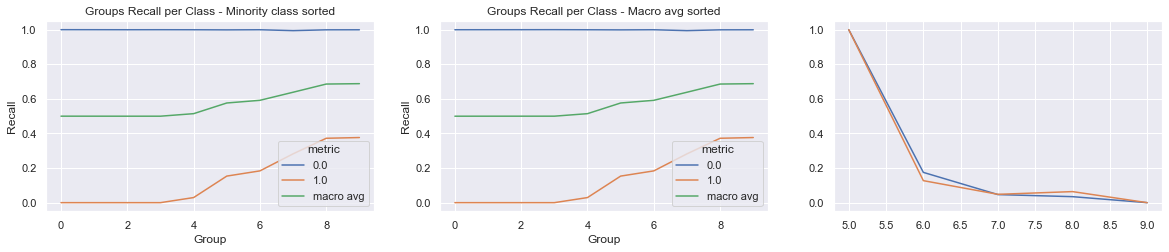

In [11]:
CP_multi = ClassificationPipeline(
    n_splits=n_splits,
    train_size=train_size, test_size=test_size,
    train_prct=train_prct, test_prct=test_prct,
    shuffle=True, random_state=seed,
)

Yi = group_ts.loc[X.index].drop('58', 1)
Groups =  Yi.apply(groupConsecutiveFlags)

scrs, cls_cnts = CP_multi.binary_multi_target(
    Xf, Yi.iloc[:, :10], model=model,
    groups=Groups, strategy='GroupShuffleSplit'
)

axs = classesGroupRecall(scrs, cls_cnts, ignore_first=5)

---
# Evaluate with cross validation

In [12]:
main_metrics = ['test_recall-0', 'test_recall-1', 'test_precision-1']
main_stats = ['mean', 'min', 'max', 'std']

### Group K Fold Cross validation Split

In [13]:
splitter = MinorityGroupSplitUndersample(
    n_splits=5,
    train_size=train_size, test_size=test_size,
    train_prct=train_prct, test_prct=test_prct,
    random_state=seed,
)

cv = list(splitter.split(
    Xf, Y, groups, strategy='GroupKFold'
))

kfold_scr = pd.DataFrame(cross_validate(
    model, Xf, Y, cv=cv,
    scoring=scoring,
    n_jobs=-1, verbose=5,
))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  7.9min remaining: 11.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 11.4min finished


#### Score statistical descriptions

In [14]:
print('\n', 'Group kfold scores')
display(
    kfold_scr[main_metrics],
    kfold_scr[main_metrics].describe().loc[['mean', 'min', 'max']]
)


 Group kfold scores


,test_recall-0,test_recall-1,test_precision-1
0,0.999302,0.392405,0.756098
1,0.998779,0.310127,0.583333
2,0.999193,0.401274,0.732558
3,0.999040,0.412903,0.703297
4,0.999253,0.406452,0.750000


,test_recall-0,test_recall-1,test_precision-1
mean,0.999114,0.384632,0.705057
min,0.998779,0.310127,0.583333
max,0.999302,0.412903,0.756098


### Shuffle Group Split Cross Validation

In [15]:
splitter = MinorityGroupSplitUndersample(
    n_splits=25,
    train_size=train_size, test_size=test_size,
    train_prct=train_prct, test_prct=test_prct,
    random_state=seed,
)

cv = list(splitter.split(
    Xf, Y, groups, strategy='GroupShuffleSplit'
))

group_shuffle_scr = pd.DataFrame(cross_validate(
    model, Xf, Y,
    cv=cv, scoring=scoring,
    n_jobs=-1, verbose=5,
))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 18.6min
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 38.4min finished


### Compare results

#### Score statistical descriptions

In [16]:
print('Group shuffle split scores description')
display(group_shuffle_scr.describe().loc[main_stats, main_metrics])

Group shuffle split scores description


,test_recall-0,test_recall-1,test_precision-1
mean,0.999136,0.331636,0.665621
min,0.998838,0.157676,0.527778
max,0.999453,0.451264,0.766234
std,0.000162,0.082163,0.068111


#### Score distribution

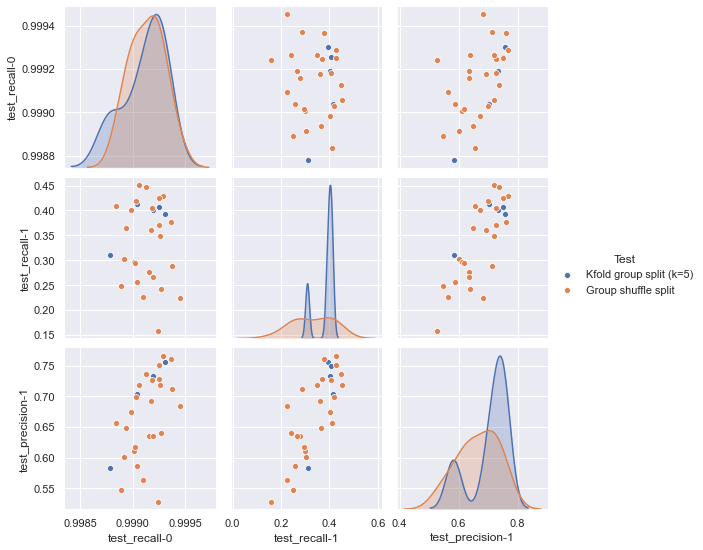

In [17]:
kfold_scr['Test'] = 'Kfold group split (k=5)'
group_shuffle_scr['Test'] = 'Group shuffle split'
cv_scrs = pd.concat([kfold_scr, group_shuffle_scr])

ax = sns.pairplot(cv_scrs[main_metrics + ['Test']], diag_kind='kde', hue='Test')

---
# Learning curve evaluation

[learning_curve] Training set sizes: [  1140   4561  10263  18245  28509  41053  55878  72983  92369 114037]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  50 | elapsed:  3.5min remaining: 21.3min
[Parallel(n_jobs=-1)]: Done  18 out of  50 | elapsed:  9.9min remaining: 17.5min
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed: 17.3min remaining: 12.5min
[Parallel(n_jobs=-1)]: Done  40 out of  50 | elapsed: 24.1min remaining:  6.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 34.8min finished


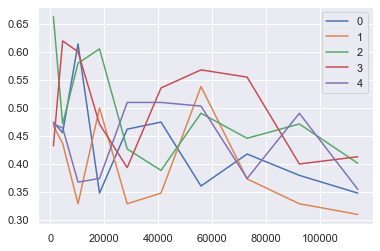

In [18]:
from sklearn.model_selection import learning_curve

splitter = MinorityGroupSplitUndersample(
    n_splits=n_splits,
    train_size=train_size, test_size=test_size,
    train_prct=train_prct, test_prct=test_prct,
    random_state=seed,
)

cv = list(splitter.split(
    Xf, Y, groups, strategy='GroupKFold'
))

lc = learning_curve(
    model, Xf, Y, cv=cv,
    scoring=scoring['recall'],
    train_sizes=np.arange(0.1, 1.1, .1)**2,
    shuffle=True, random_state=seed,
    n_jobs=-1, verbose=5,
)

lc_df = pd.DataFrame(lc[2], index=lc[0])

ax = lc_df.plot()

---
# Time based splits

#### Evaluate splits

In [33]:
from sklearn.model_selection import TimeSeriesSplit

years = 4.5
test_year_fraction = 1 / 8 # year fraction for testing
steps = int(years / test_year_fraction)  # Number of equal size folders including test folder
test_size = int(len(Y) / steps) 

tss = TimeSeriesSplit(n_splits=9, max_train_size=None, test_size=None)

cv = list(tss.split(Xf, Y, groups=groups))

scr_ts = pd.DataFrame(cross_validate(
    model, Xf, Y, cv=cv,
    scoring=scoring,
    n_jobs=-1, verbose=5
))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:  7.3min remaining:  9.2min
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed: 10.8min remaining:  5.4min
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed: 15.3min finished


### Incremental learning curve

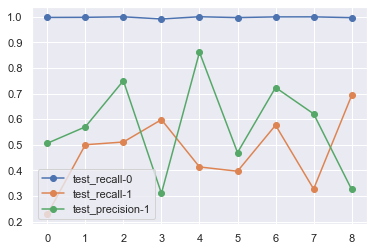

In [55]:
ax = scr_ts[['test_recall-0', 'test_recall-1', 'test_precision-1']].plot(marker='o')

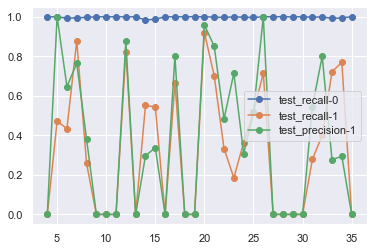

In [30]:
ax = scr_ts[['test_recall-0', 'test_recall-1', 'test_precision-1']].plot(marker='o')